In [2]:
%load_ext autoreload
%autoreload 2

import os
import random
from abc import abstractmethod
from os.path import join as oj
from tqdm import tqdm
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Memory
import seaborn as sns
from sklearn.neighbors import KernelDensity   
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import rulevetting
import rulevetting.api.viz as viz
from rulevetting.projects.tbi_pecarn.dataset import Dataset
from rulevetting.projects.tbi_pecarn import helper
from rulevetting.projects.tbi_pecarn import graph

%matplotlib inline
%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'rulevetting' from '__main__' (unknown location)

In [298]:
# loading in the data - edit below path
data_path = '/Users/marko/rule-vetting/data'
df = Dataset().clean_data(data_path = data_path)

Reading the raw CSVs... ['TBI PUD 10-08-2013.csv', 'TBI PUD Imaging.csv', 'TBI PUD Neuro.csv']


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


/Users/marko/rule-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Fraction of Missingness'>

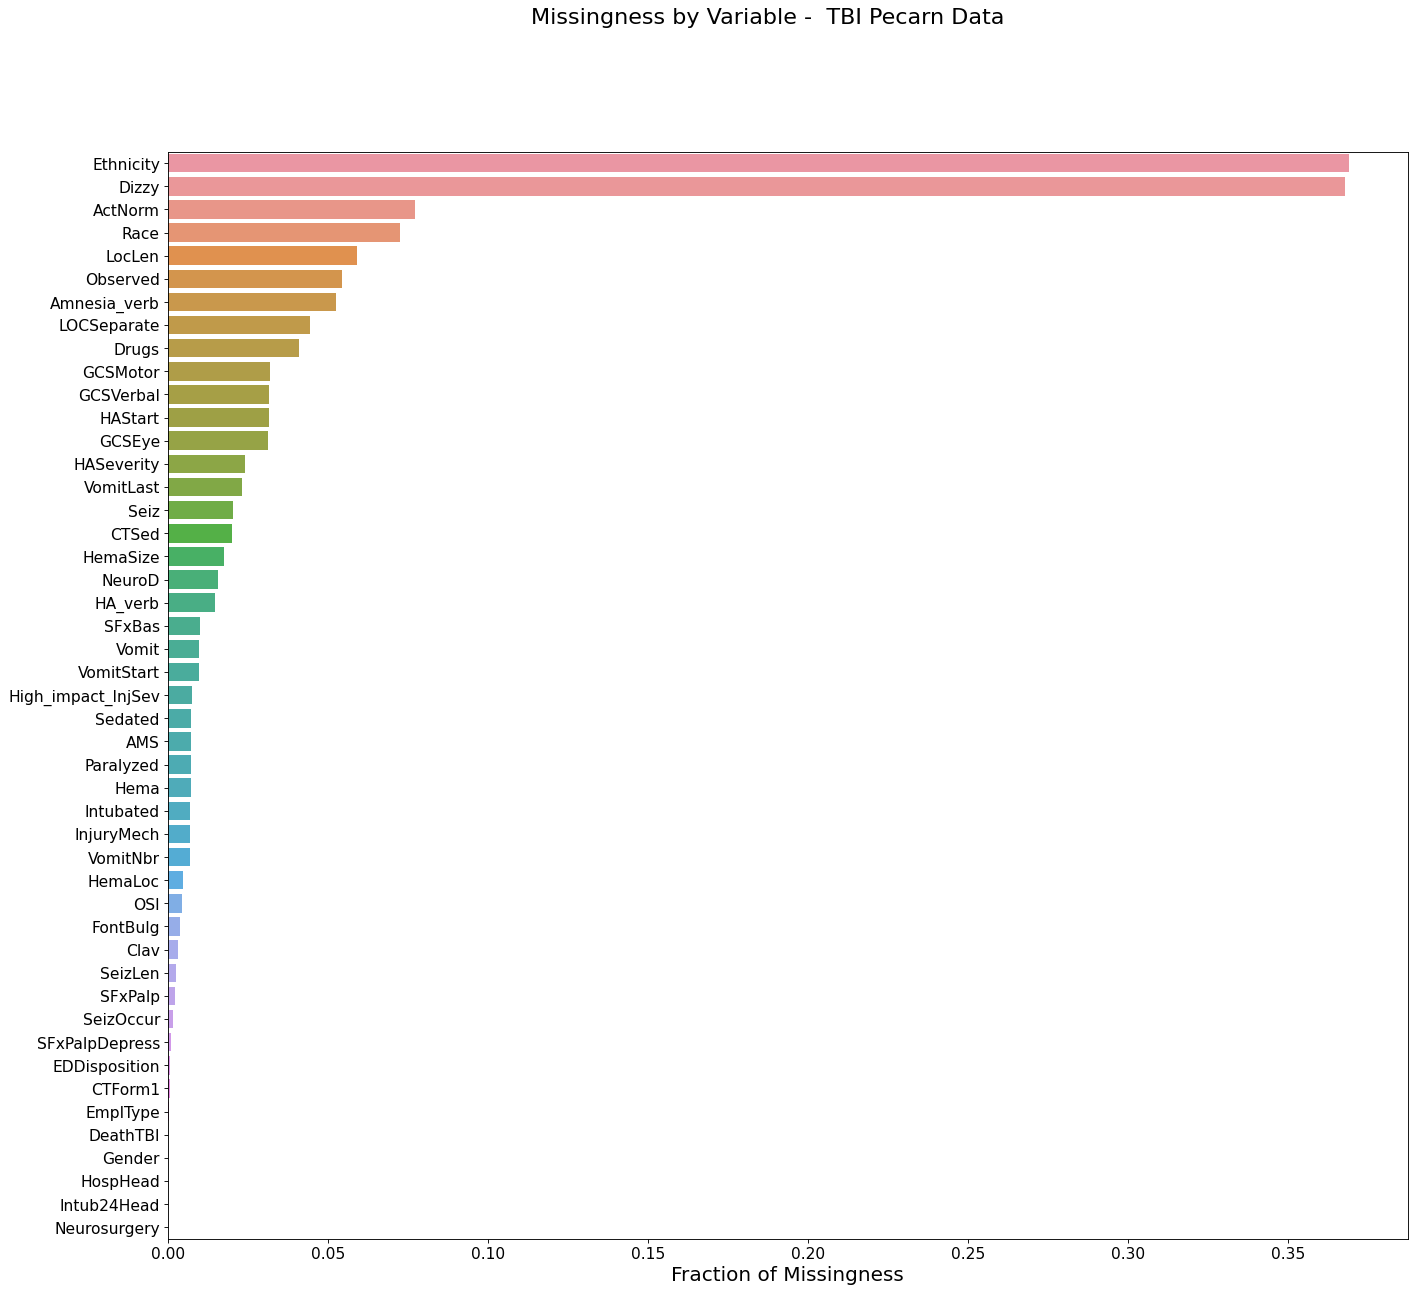

In [449]:
pd.set_option('display.max_columns', 100)
na_col_counts = df.apply(lambda col: (col == 'Unknown').mean())
na_col_counts = na_col_counts[na_col_counts > 0]
na_col_counts = na_col_counts.sort_values(ascending=False)
barplot(na_col_counts, 
        False, 
        "Missingness by Variable -  TBI Pecarn Data",
        "Fraction of Missingness"
)

The above plot shows dizziness and ethnicity as the two most missing features by far. I assume as the GCS score is 14-15, that dizziness is implied and so maybe it's skipped over in the form but for ethnicity I'm not sure but race does not have the same % missing. <insert other stuff about this here to deal with>...

From the 'TBI PUD 10-08-2013.csv', there seem to be 20 patients without the outcome variable PosIntFinal. However in the frequencies of categorical variables, the union of missing Intub24Head, Neurosurgery, HospHeadPosCT, and DeathTBI is 1 which means at most 1 of the 20 cannot be inferred from these. As seen below, it turns out that we can infer all of these outcomes which results in no missing outcomes from our data set.  

In [220]:
def infer_missing_outcome(row):
    outcome = 'Unknown'
    # look at known outcome columns to infer outcome
    not_missing = [data for data in row if data != 'Unknown']
    
    # if all values that are known give the same answer, use that as the outcome
    if len(not_missing) > 0 and not_missing.count(not_missing[0]) == len(not_missing):
        outcome = not_missing[0]
    return outcome

outcome_vars = ['HospHeadPosCT', 'Intub24Head', 'Neurosurgery', 'DeathTBI']
df.loc[df['PosIntFinal'] == 'Unknown', 'PosIntFinal'] = df[df['PosIntFinal'] == 'Unknown'][outcome_vars].apply(infer_missing_outcome, axis=1)

Now we can pivot to see if similar analysis can be applied to our features. I first noticed HospHead has 3 missing values while HospHeadPosCT which is the intersection of HospHead and TBI on CT which has zero missing values. These all yield no however alongside PosCT which can imply HospHead was occured but there was no TBI on CT - hence we leave it as is.

In [232]:
df.loc[df['HospHead'] == 'Unknown', ['HospHead', 'PosCT', 'HospHeadPosCT']] 

,HospHead,PosCT,HospHeadPosCT
id,,,
76,Unknown,No,No
9542,Unknown,No,No
42816,Unknown,No,No


To decide if there are entire columns we would want to remove, it may prove luxuriant to examine the distribution of missing values per observation - as seen below, the 25-75th percentile averages around 7-16 missing columns whereas there are a plethora on the high end - we'll find out which ones these are and if they need to be removed.

<AxesSubplot:>

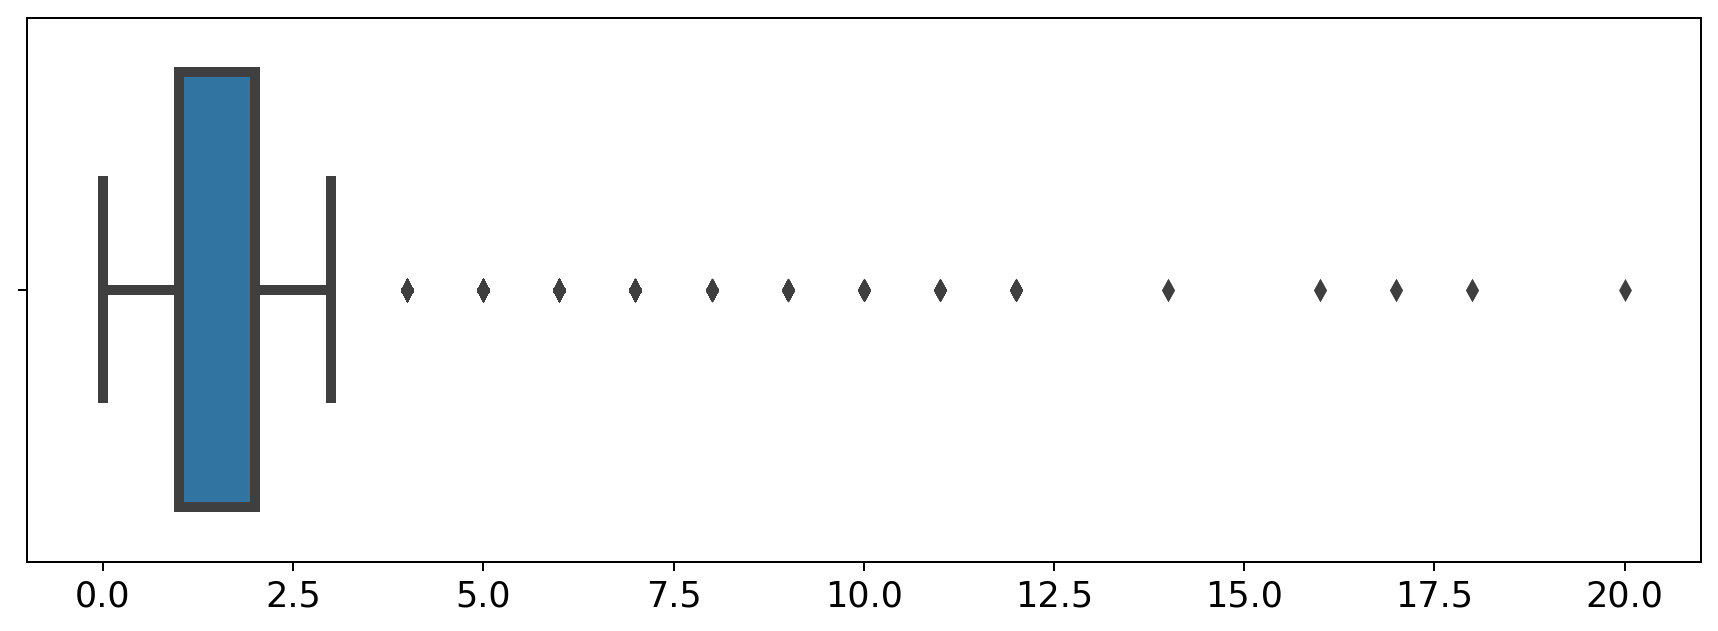

In [446]:
# plotting distribution of missing values per each row of the main data set
X = df.apply(lambda col: (col == 'Unknown').sum(), axis=1).to_numpy().reshape(-1, 1)
fig, ax = plt.subplots(figsize=(12,4))
sns.boxplot(x=X)

Here we can look at our only two/three features that aren't categorical and get a better sense of the distribution - sns uses a Gaussian kde I believe as default.

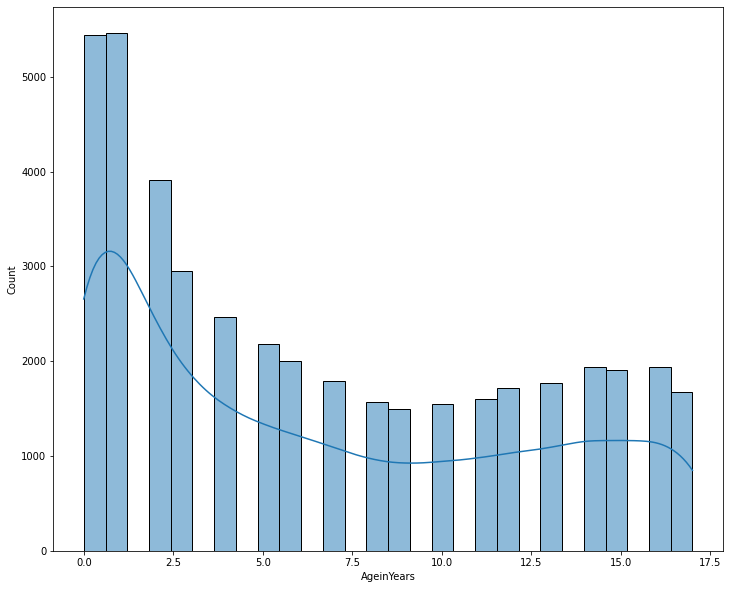

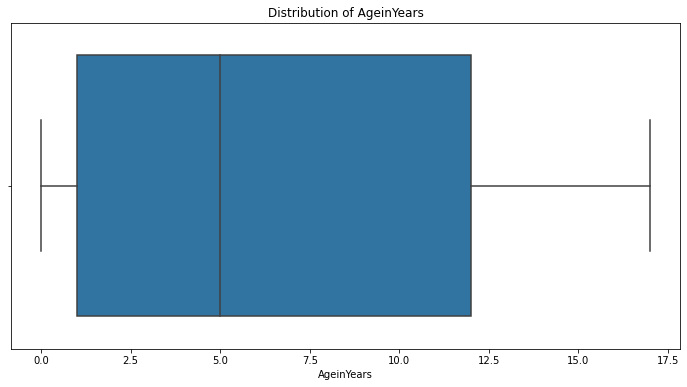

In [438]:
# looking at the distributions of data - this is a pseudo function - change top params
dist_plot = True
boxplot_plot = True
feature = 'AgeinYears'
title = f'Distribution of {feature}'

if dist_plot:
    fig, ax = plt.subplots(figsize=(12,10))
    sns.histplot(data=df, x=feature, kde=True)

if boxplot_plot:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_title(title)
    ax = sns.boxplot(data=df, x=feature)

Now is a good time before continuing EDA to partition the data into train, validation, and a test set to not bias our model selection a priori observing the distributions and correlations.

In [439]:
cleaned_df = Dataset().clean_data(data_path = data_path)
preprocessed_df = Dataset().preprocess_data(cleaned_df)
df_train, df_tune, _ = Dataset().split_data(preprocessed_df)
df = df_train

Reading the raw CSVs... ['TBI PUD 10-08-2013.csv', 'TBI PUD Imaging.csv', 'TBI PUD Neuro.csv']


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s]


Below we see the strongest features in terms of absolute correlation to the outcome. There are notable features that are implicitly defined as the outcome such as deathTBI which is part of the outcome so we'd expect such a strong correlation to exist. Other noteworthy features include several of the unknowns/missing one-hot encoded features which means maybe we can infer from somewhere else how this implies the patient does or does not have ciTBI...

/Users/marko/rule-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/marko/rule-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Outcome Correlation'>

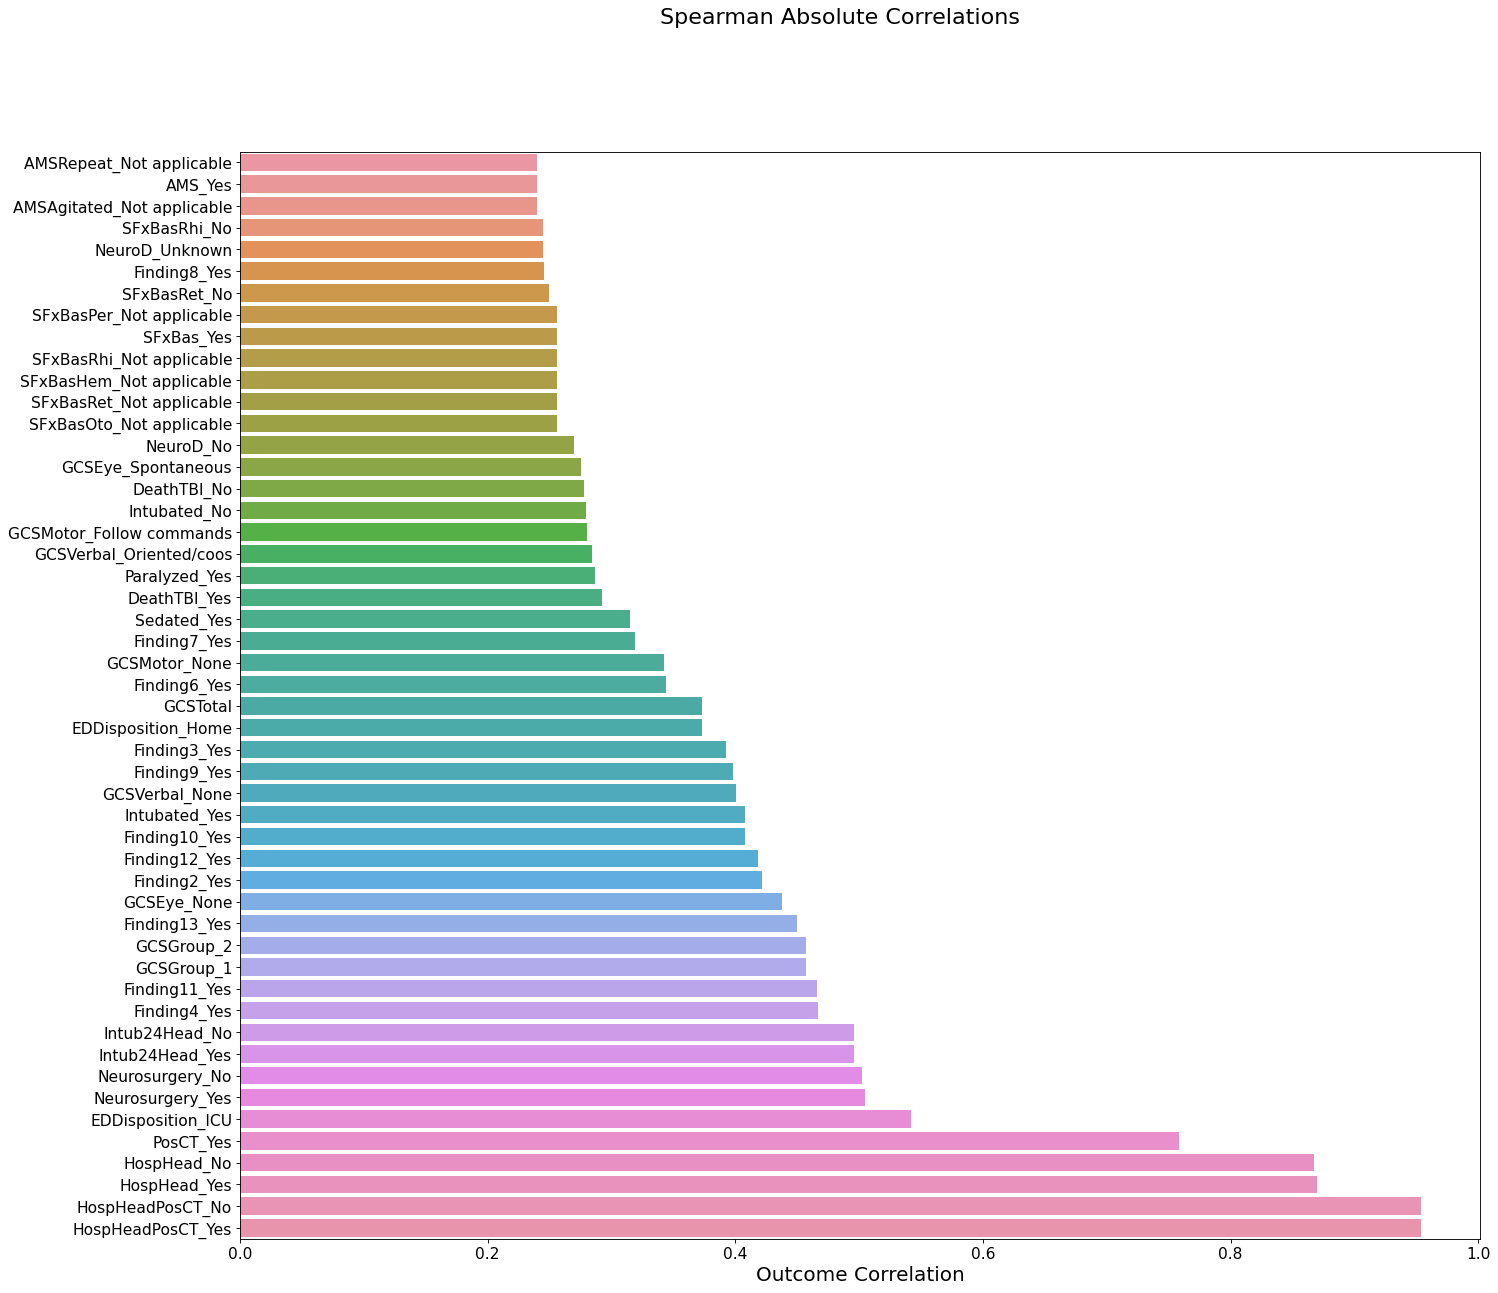

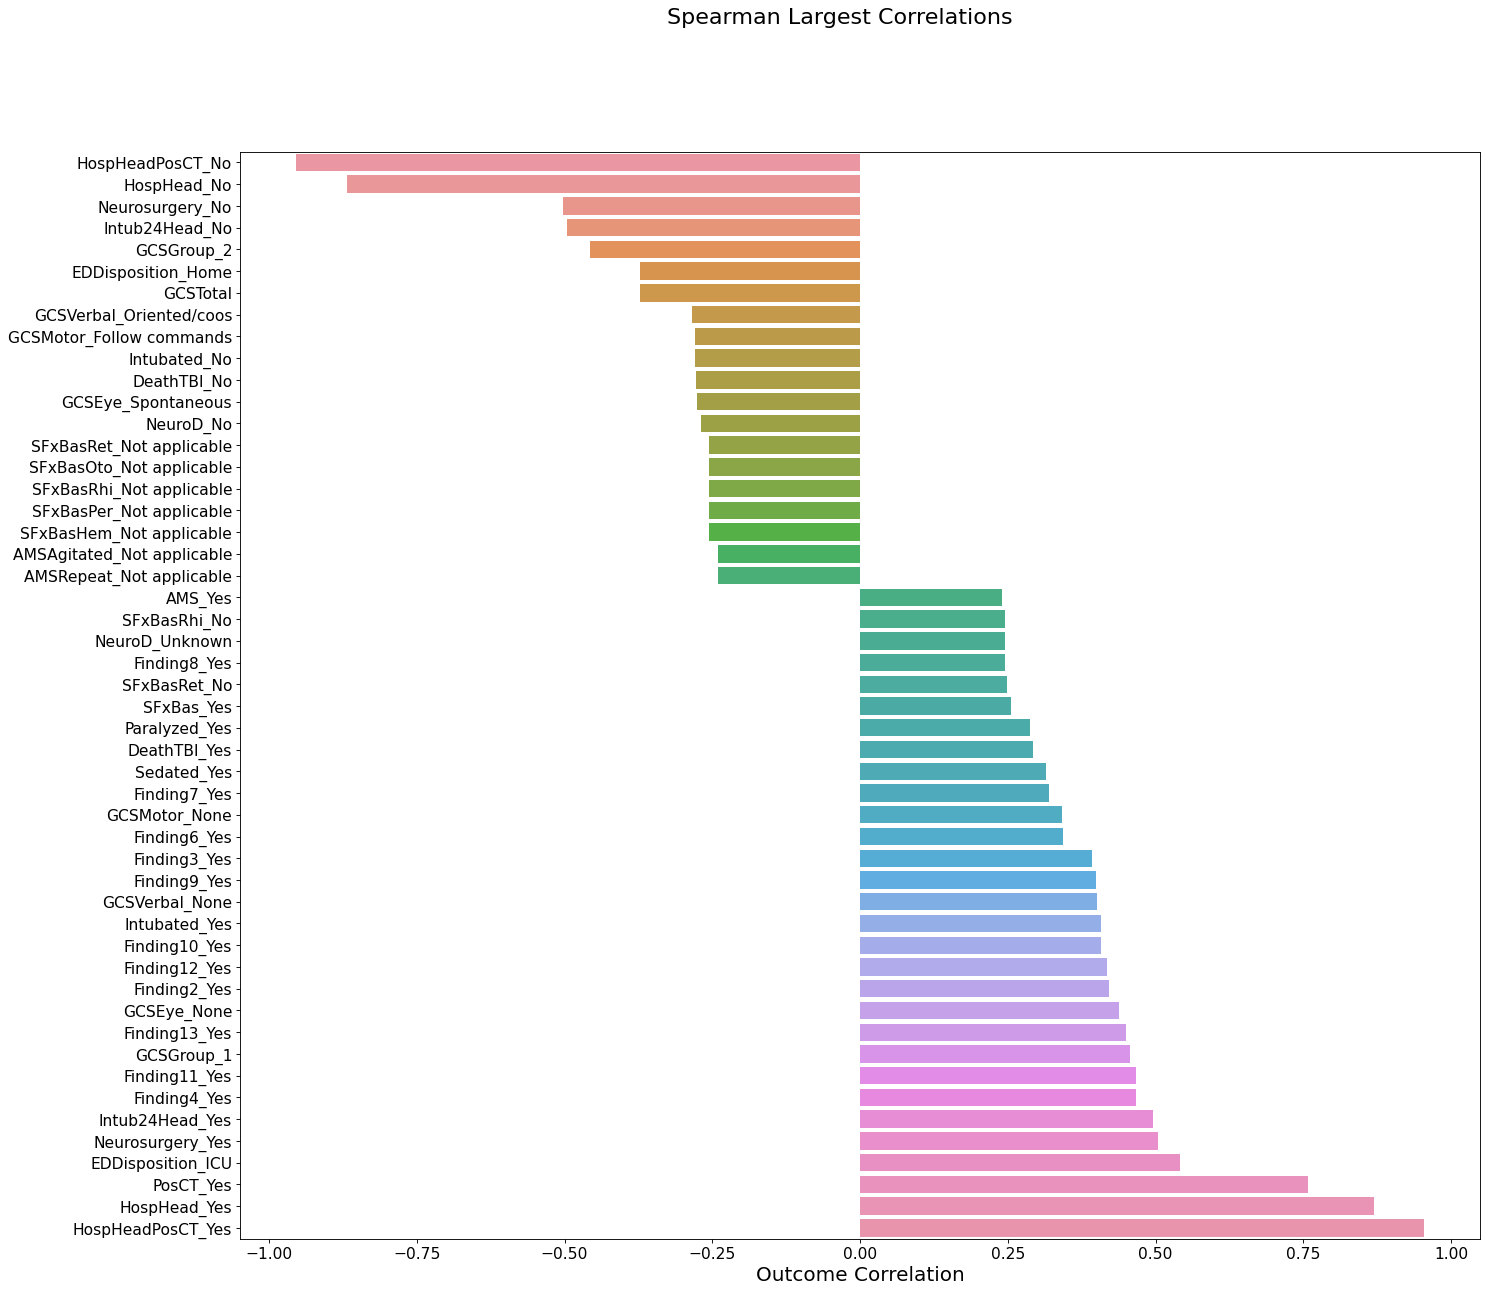

In [443]:
one_hot_df = helper.one_hot_encode_df(df)
corr = one_hot_df.drop(['outcome_No', 'outcome_Yes'], axis=1).apply(lambda x: x.corr(one_hot_df['outcome_Yes'], method='spearman'))

# largest in absolute value
abs_corr = corr.abs().sort_values(ascending=True)
barplot(abs_corr[-50:], savefig=False, title='Spearman Absolute Correlations', xlab='Outcome Correlation')

# sorted by absolute value
largest_corr = corr.iloc[corr.abs().argsort()][-50:].sort_values(ascending=True)
barplot(largest_corr, savefig=False, title='Spearman Largest Correlations', xlab='Outcome Correlation')

Now we plot the distributions of some of the features with the most correlated encodings:

Text(0.5, 141.00000000000043, 'Count')

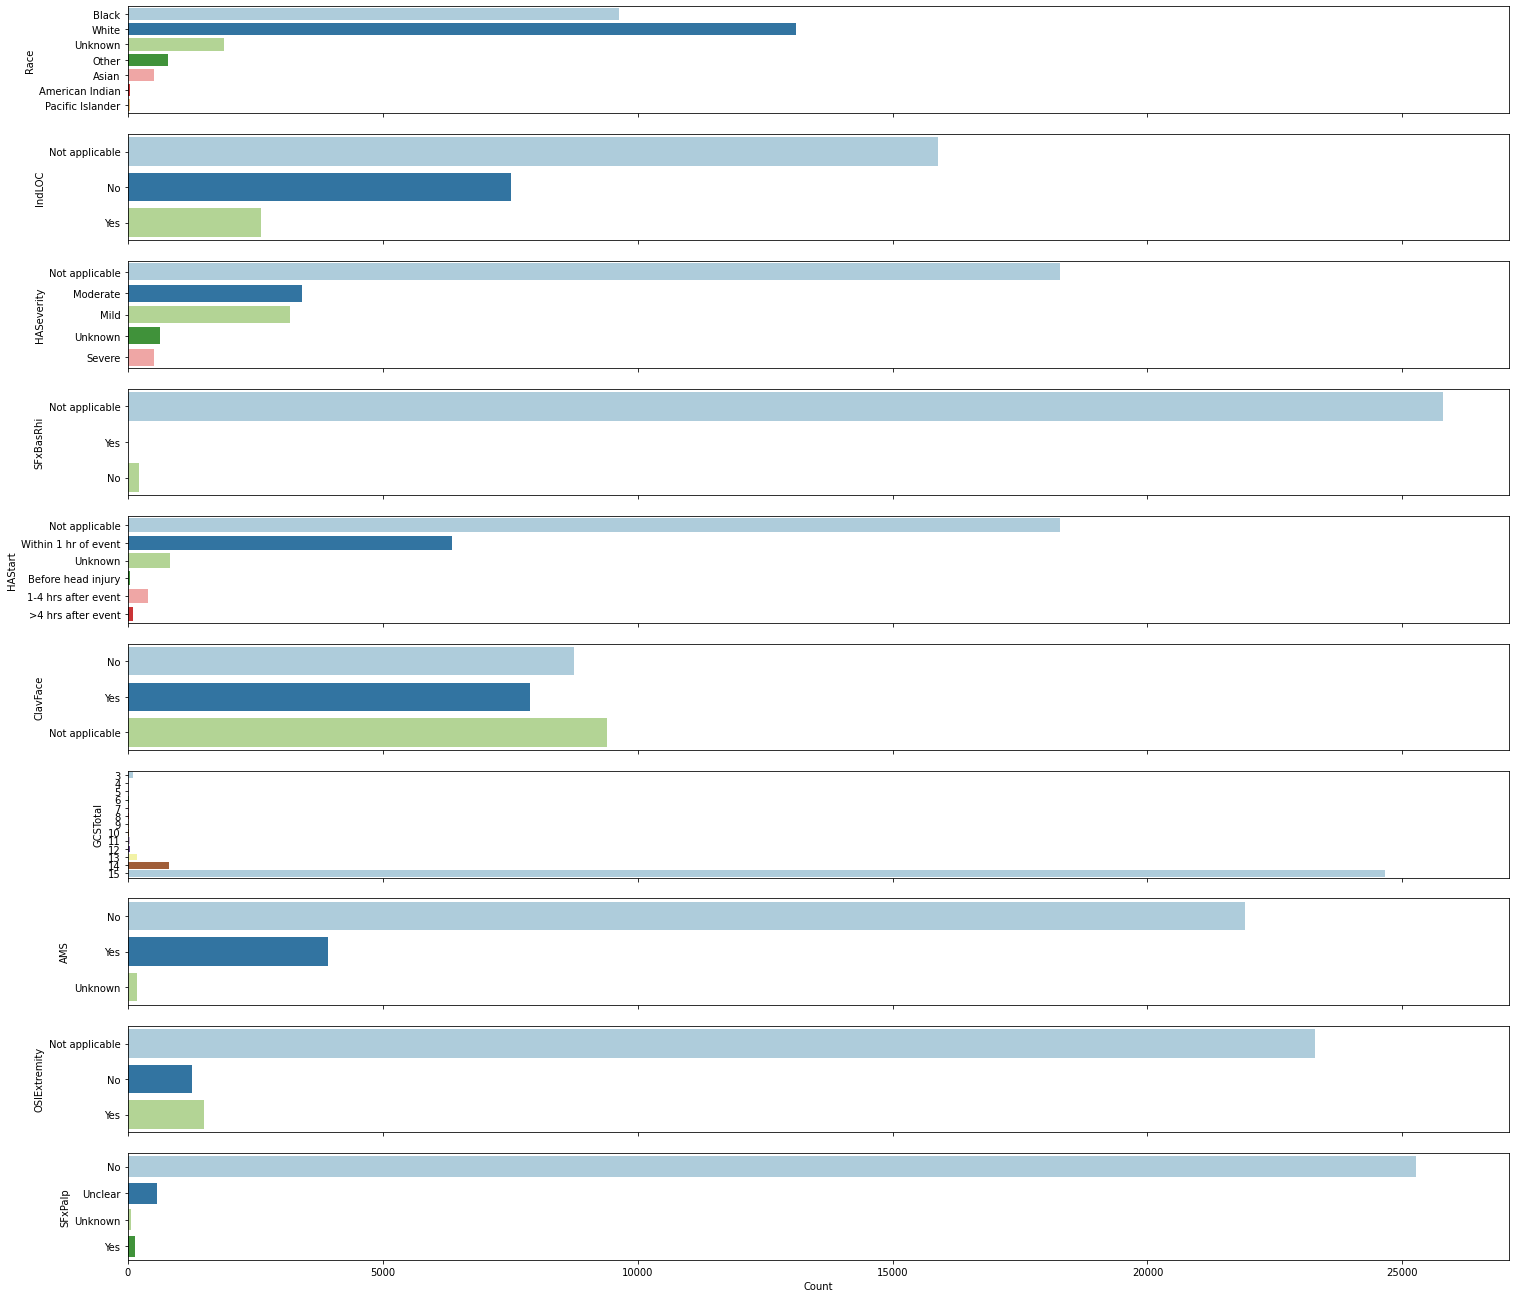

In [386]:
plot_count = 10
correlated_feats = list(set([feat.split('_')[0] for feat in abs_corr.index.tolist()]))
fig, axs = plt.subplots(nrows=plot_count, sharex=True,  figsize=(20,18))
fig.tight_layout()
for i in range(plot_count):
    sns.countplot(y=correlated_feats[i], data=df, ax=axs[i], palette="Paired")
    axs[i].set_xlabel('')
plt.xlabel('Count')

Code below takes to long to run as there are too many features at the moment. It simply displays the correlation heatmap... Instead we can skip over this and perform PCA on the one-hot-encoded data to maybe condense our space.

In [451]:
# plotting correlation of all features - one-hot encode features
'''
corr = one_hot_df.corr(method='kendall')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
'''

'\ncorr = one_hot_df.corr(method=\'kendall\')\n\n# Generate a mask for the upper triangle\nmask = np.triu(np.ones_like(corr, dtype=bool))\n\n# Set up the matplotlib figure\nf, ax = plt.subplots(figsize=(11, 9))\n\n# Generate a custom diverging colormap\ncmap = sns.diverging_palette(230, 20, as_cmap=True)\n\n# Draw the heatmap with the mask and correct aspect ratio\nsns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,\n            square=True, linewidths=.5, cbar_kws={"shrink": .5})\n'

Here is Hyunsuk's bit about PCA: 

In [12]:
# Temporary #####
filename = "../../../../data/tbi_pecarn/raw/TBI PUD 10-08-2013.csv"
data = pd.read_csv(filename)
#################

In [43]:
# Some preprocessing - should be updated in clean_data later
# Grouped variables NA -> NO

data['AMSAgitated'] = data['AMSAgitated'].apply(lambda x : 0 if(x == 92) else x)
data['AMSSleep'] = data['AMSSleep'].apply(lambda x : 0 if(x == 92) else x)
data['AMSSlow'] = data['AMSSlow'].apply(lambda x : 0 if(x == 92) else x)
data['AMSRepeat'] = data['AMSRepeat'].apply(lambda x : 0 if(x == 92) else x)
data['AMSOth'] = data['AMSOth'].apply(lambda x : 0 if(x == 92) else x)

data['SFxBasHem'] = data['SFxBasHem'].apply(lambda x : 0 if(x == 92) else x)
data['SFxBasOto'] = data['SFxBasOto'].apply(lambda x : 0 if(x == 92) else x)
data['SFxBasPer'] = data['SFxBasPer'].apply(lambda x : 0 if(x == 92) else x)
data['SFxBasRet'] = data['SFxBasRet'].apply(lambda x : 0 if(x == 92) else x)
data['SFxBasRhi'] = data['SFxBasRhi'].apply(lambda x : 0 if(x == 92) else x)

data['ClavFace'] = data['ClavFace'].apply(lambda x : 0 if(x == 92) else x)
data['ClavNeck'] = data['ClavNeck'].apply(lambda x : 0 if(x == 92) else x)
data['ClavFro'] = data['ClavFro'].apply(lambda x : 0 if(x == 92) else x)
data['ClavOcc'] = data['ClavOcc'].apply(lambda x : 0 if(x == 92) else x)
data['ClavPar'] = data['ClavPar'].apply(lambda x : 0 if(x == 92) else x)
data['ClavTem'] = data['ClavTem'].apply(lambda x : 0 if(x == 92) else x)

data['NeuroD'] = data['NeuroD'].apply(lambda x : 0 if(x == 92) else x)
data['NeuroDMotor'] = data['NeuroDMotor'].apply(lambda x : 0 if(x == 92) else x)
data['NeuroDSensory'] = data['NeuroDSensory'].apply(lambda x : 0 if(x == 92) else x)
data['NeuroDCranial'] = data['NeuroDCranial'].apply(lambda x : 0 if(x == 92) else x)
data['NeuroDReflex'] = data['NeuroDReflex'].apply(lambda x : 0 if(x == 92) else x)
data['NeuroDOth'] = data['NeuroDOth'].apply(lambda x : 0 if(x == 92) else x)

data['OSIExtremity'] = data['OSIExtremity'].apply(lambda x : 0 if(x == 92) else x)
data['OSICut'] = data['OSICut'].apply(lambda x : 0 if(x == 92) else x)
data['OSICspine'] = data['OSICspine'].apply(lambda x : 0 if(x == 92) else x)
data['OSIFlank'] = data['OSIFlank'].apply(lambda x : 0 if(x == 92) else x)
data['OSIAbdomen'] = data['OSIAbdomen'].apply(lambda x : 0 if(x == 92) else x)
data['OSIPelvis'] = data['OSIPelvis'].apply(lambda x : 0 if(x == 92) else x)
data['OSIOth'] = data['OSIOth'].apply(lambda x : 0 if(x == 92) else x)

data['IndAge'] = data['IndAge'].apply(lambda x : 0 if(x == 92) else x)
data['IndAmnesia'] = data['IndAmnesia'].apply(lambda x : 0 if(x == 92) else x)
data['IndAMS'] = data['IndAMS'].apply(lambda x : 0 if(x == 92) else x)
data['IndClinSFx'] = data['IndClinSFx'].apply(lambda x : 0 if(x == 92) else x)
data['IndHA'] = data['IndHA'].apply(lambda x : 0 if(x == 92) else x)
data['IndHema'] = data['IndHema'].apply(lambda x : 0 if(x == 92) else x)
data['IndLOC'] = data['IndLOC'].apply(lambda x : 0 if(x == 92) else x)
data['IndMech'] = data['IndMech'].apply(lambda x : 0 if(x == 92) else x)
data['IndNeuroD'] = data['IndNeuroD'].apply(lambda x : 0 if(x == 92) else x)
data['IndRqstMD'] = data['IndRqstMD'].apply(lambda x : 0 if(x == 92) else x)
data['IndRqstParent'] = data['IndRqstParent'].apply(lambda x : 0 if(x == 92) else x)
data['IndRqstTrauma'] = data['IndRqstTrauma'].apply(lambda x : 0 if(x == 92) else x)
data['IndSeiz'] = data['IndSeiz'].apply(lambda x : 0 if(x == 92) else x)
data['IndVomit'] = data['IndVomit'].apply(lambda x : 0 if(x == 92) else x)
data['IndXraySFx'] = data['IndXraySFx'].apply(lambda x : 0 if(x == 92) else x)
data['IndOth'] = data['IndOth'].apply(lambda x : 0 if(x == 92) else x)

df = data
df=df.rename(columns = {'PosIntFinal':'outcome'})

In [46]:
data2.columns

Index(['EmplType', 'Certification', 'InjuryMech', 'High_impact_InjSev',
       'Amnesia_verb', 'LOCSeparate', 'LocLen', 'Seiz', 'SeizOccur', 'SeizLen',
       'ActNorm', 'HA_verb', 'HASeverity', 'HAStart', 'Vomit', 'VomitNbr',
       'VomitStart', 'VomitLast', 'Intubated', 'Paralyzed', 'Sedated',
       'GCSEye', 'GCSVerbal', 'GCSMotor', 'GCSTotal', 'GCSGroup', 'AMS',
       'AMSAgitated', 'AMSSleep', 'AMSSlow', 'AMSRepeat', 'AMSOth', 'SFxPalp',
       'SFxPalpDepress', 'FontBulg', 'SFxBas', 'SFxBasHem', 'SFxBasOto',
       'SFxBasPer', 'SFxBasRet', 'SFxBasRhi', 'Hema', 'HemaLoc', 'HemaSize',
       'Clav', 'ClavFace', 'ClavNeck', 'ClavFro', 'ClavOcc', 'ClavPar',
       'ClavTem', 'NeuroD', 'NeuroDMotor', 'NeuroDSensory', 'NeuroDCranial',
       'NeuroDReflex', 'NeuroDOth', 'OSI', 'OSIExtremity', 'OSICut',
       'OSICspine', 'OSIFlank', 'OSIAbdomen', 'OSIPelvis', 'OSIOth', 'Drugs',
       'IndAge', 'IndAmnesia', 'IndAMS', 'IndClinSFx', 'IndHA', 'IndHema',
       'IndLOC', 'IndMech', '

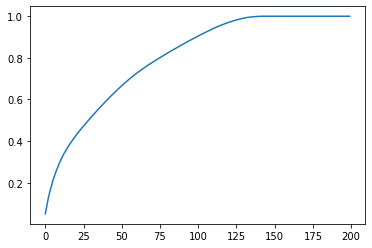

In [45]:
data1 = df.drop(['Race', 'Observed', 'Ethnicity', 'Dizzy', 
                 #'IndAge', 'IndAmnesia', 'IndAMS', 'IndClinSFx', 'IndHA', 'IndHema', 'IndLOC',
                 #'IndMech', 'IndNeuroD', 'IndRqstMD', 'IndRqstParent', 'IndRqstTrauma', 'IndSeiz', 
                 #'IndVomit', 'IndXraySFx', 'IndOth',
                 'CTForm1', 'CTSed', 'CTSedAgitate', 'CTSedAge', 'CTSedRqst', 'CTSedOth'], axis = 1).dropna()

data2 = data1.iloc[:,1:88]
data2_age = data2[['AgeInMonth', 'AgeinYears']]
data2_noage = data2.drop(['AgeInMonth', 'AgeinYears'], axis = 1)   # Categorical Outcomes

# One-hot encoding
data3 = pd.get_dummies(data2_noage, columns = list(data2_noage.columns))
data4 = pd.concat([data3, data2_age], axis=1)   # (28861, 245)

data4_scaled = StandardScaler().fit_transform(data4)

# Conducting PCA 
pca = PCA().fit(data4_scaled) 
explained_variance = np.copy(pca.explained_variance_ratio_)
explained_variance_sum = explained_variance

# Variance explained
for i in range(1, len(explained_variance_sum)) :
    explained_variance_sum[i] += explained_variance_sum[i-1] 

# Scree Plot
plt.plot(explained_variance_sum[0:200])

# PC Scores
pc_score = pca.transform(data4_scaled)


# Outcome of each patients (to color, size the scatter plot below)
posint_col = np.where(data1['outcome'] == 1, '#ff0f0e', '#1f77b4')
posint_sz = np.where(data1['outcome'] == 1, 7, 0.7)



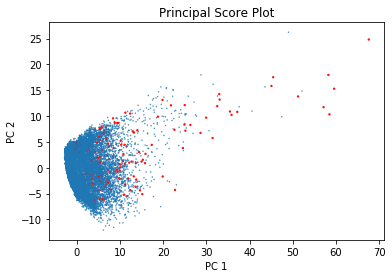

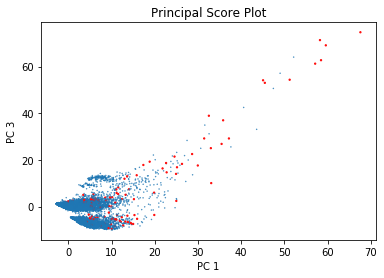

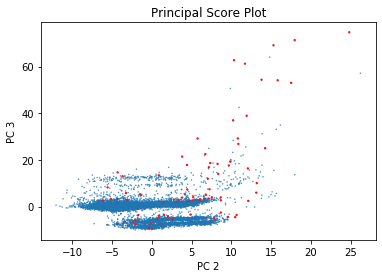

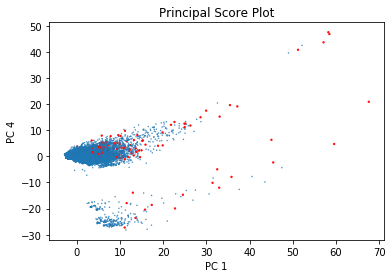

In [47]:

# PC PLOT 1 2(RED DOTS : PosIntFinal == 1)  
# THIS PART SHOULD BE CHANGED INTO A FUNCTION LATER
# Total : 28223 / PosIntFinal == 1 : 160
plt.figure()
plt.title("Principal Score Plot")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.scatter(pc_score[:,0], pc_score[:,1], c = posint_col, s = posint_sz, alpha = 1, marker = '.')

# PC PLOT 1 3
plt.figure()
plt.title("Principal Score Plot")
plt.xlabel("PC 1")
plt.ylabel("PC 3")
plt.scatter(pc_score[:,0], pc_score[:,2], c = posint_col, s = posint_sz, alpha = 1, marker = '.')

# PC PLOT 2 3
plt.figure()
plt.title("Principal Score Plot")
plt.xlabel("PC 2")
plt.ylabel("PC 3")
plt.scatter(pc_score[:,1], pc_score[:,2], c = posint_col, s = posint_sz, alpha = 1, marker = '.')


# PC PLOT 1 4
plt.figure()
plt.title("Principal Score Plot")
plt.xlabel("PC 1")
plt.ylabel("PC 4")
plt.scatter(pc_score[:,0], pc_score[:,3], c = posint_col, s = posint_sz, alpha = 1, marker = '.')

In [60]:
# Lastly, let's see what contributes to PC3 (3 Groups), PC4 (2 Groups) the most
print(data4.columns[np.where(pca.components_[0,:] > 0.145, True, False)]) # - Related to Acting normally, AMS (Altered Mental Status)
print(data4.columns[np.where(pca.components_[1,:] > 0.2, True, False)]) # - Related to Age (< 2 or pre-verbal)

print(data4.columns[np.where(pca.components_[2,:] > 0.2, True, False)]) # - Related to Vomit
print(data4.columns[np.where(pca.components_[3,:] > 0.2, True, False)]) # - Related to Seize

print(data4.columns[np.where(pca.components_[4,:] > 0.15, True, False)]) # - Related to Intubted, Paralyzed, GCS scores
print(data4.columns[np.where(pca.components_[5,:] > 0.15, True, False)]) # - Related to Hematoma or swelling
print(data4.columns[np.where(pca.components_[6,:] > 0.2, True, False)]) # - Related to Neurological Deficit
print(data4.columns[np.where(pca.components_[7,:] > 0.2, True, False)]) # - Related to Neurological Deficit


# Checking the PC loading
pc_which = 7
pca.components_[pc_which, np.where(pca.components_[pc_which,:] > 0.1, True, False)]

Index(['ActNorm_0.0', 'AMS_1.0'], dtype='object')
Index(['Amnesia_verb_91.0', 'HA_verb_91.0', 'HASeverity_92.0', 'HAStart_92.0',
       'AgeTwoPlus_1'],
      dtype='object')
Index(['Vomit_0.0', 'VomitNbr_92.0', 'VomitStart_92.0', 'VomitLast_92.0'], dtype='object')
Index(['Seiz_0.0', 'SeizOccur_92.0', 'SeizLen_92.0', 'IndSeiz_0'], dtype='object')
Index(['Intubated_1.0', 'Paralyzed_1.0', 'GCSEye_1.0', 'GCSVerbal_1.0',
       'GCSMotor_1.0', 'GCSTotal_3', 'Hema_0.0', 'HemaLoc_92.0',
       'HemaSize_92.0'],
      dtype='object')
Index(['Hema_1.0', 'HemaLoc_1.0', 'HemaSize_2.0'], dtype='object')
Index(['NeuroD_0.0'], dtype='object')
Index(['NeuroD_0.0', 'NeuroDOth_0', 'IndNeuroD_0'], dtype='object')


array([0.10896992, 0.16718077, 0.19189479, 0.11220886, 0.10624327,
       0.17385364, 0.17984361, 0.25136806, 0.10010508, 0.10221751,
       0.2049555 , 0.13918213, 0.11699308, 0.11699758, 0.2081134 ])

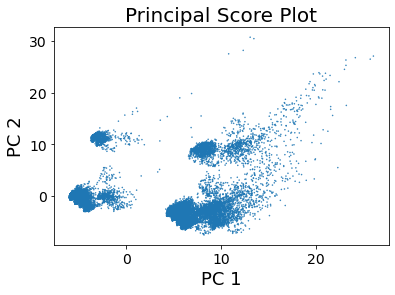

In [461]:
# CTForm1 (CT was ordered or not) contributes the most to PC1 

# How many of them were YES (CT was ordered)
sum(data1['CTForm1'] == 1)  # 8031 / 28223

# Indicating CTForm1 = Yes as red
ctform_col = np.where(data1['CTForm1'] == 1, '#ff0f0e', '#1f77b4')

plt.figure()
plt.title("Principal Score Plot")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.scatter(pc_score[:,0], pc_score[:,1], c = ctform_col, s = 1, alpha = 1, marker = '.')

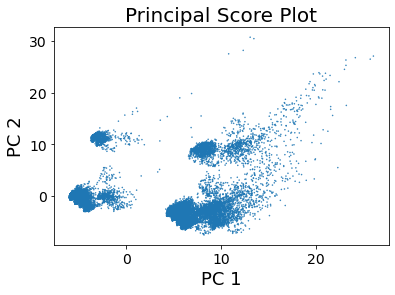

In [462]:
# OSI (other ) contributes the most to PC2

# How many of them were YES 
sum(data1['OSI'] == 1)  # 2191 / 28223

# Indicating OSI = Yes as red
osi_col = np.where(data1['OSI'] == 1, '#ff0f0e', '#1f77b4')

plt.figure()
plt.title("Principal Score Plot")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.scatter(pc_score[:,0], pc_score[:,1], c = osi_col, s = 1, alpha = 1, marker = '.')

All of the stuff below is the earlier eda stuff not by me...

# get data

In [3]:
df_train, df_tune, _ = Dataset().split_data()
df = df_train
processed_feats = df.keys().values.tolist()
print(processed_feats)

TypeError: split_data() missing 1 required positional argument: 'preprocessed_data'

**correlations between features**

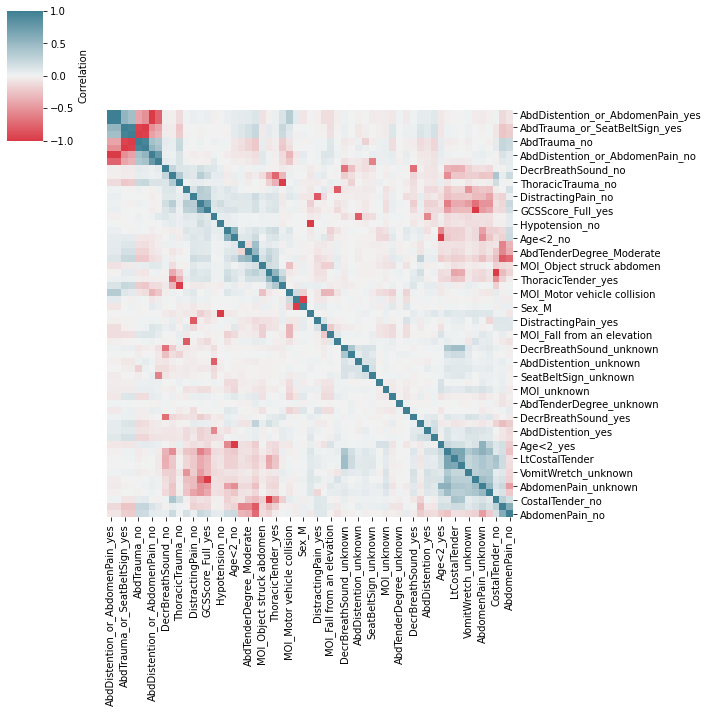

In [37]:
# corrs = df[feat_names + [outcome_def]].corr()
corrs = df[processed_feats].corr(method='pearson')
corrmap = sns.clustermap(corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
#                figsize=(12, 12))
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)

plt.show()
# plt.savefig('results/corrplot.png', dpi=300, bbox_inches='tight')